# Bucket Brigade - Nested edition

Bucket Brigade is a system for taking a large parquet file breaking it up spatially across multiple files using geohash to organize files into nested directories.

In [107]:
import os
from collections import Counter
import json

import pandas as pd
import geopandas as gpd
#import dask_geopandas
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
from shapely import wkb, wkt
import pygeohash as pgh

import ipywidgets as widgets
from IPython.display import display
import tkinter as tk
from tkinter import filedialog


## What is a GEOHash

Lets take a second to look at geo hash and what it looks like.

In [5]:
print(pgh.encode(latitude=42.6, longitude=-5.6))
print(pgh.encode(latitude=42.6, longitude=-5.6, precision=5))
print(pgh.encode(latitude=32.0, longitude=-7.0, precision=5))

print(pgh.decode(geohash='ezs42'))
print(pgh.geohash_approximate_distance(geohash_1='bcd3u', geohash_2='bc83n') /1000 ,"km")
#not found in lib???
#print(pgh.get_adjacent(geohash='kd3ybyu', direction='right'))

ezs42e44yx96
ezs42
even0
(42.6, -5.6)
625.441 km


## Settings

Pick a file and then read it in using GeoPandas

In [6]:
selected_file = "~/src/project/cmr-bigstac-prototype/bigstac/scripts_explore/3mil_no_global_bounds.parquet"

# Read the GeoParquet file
gdf = gpd.read_parquet(selected_file)

## Some utility functions

going to use these things latter on

In [108]:
# some utilities
def write_string_to_file(filename, content):
    try:
        with open(filename, 'w') as file:
            file.write(content)
        #print(f"Successfully wrote to the file {filename}")
    except IOError as e:
        print(f"An error occurred while writing to the file {filename}: {e}")

def make_geo_box(sub:str, details:dict):
  """Make a directory to store parquet files in"""
  data = f"{os.getcwd()}/data2/{sub}"
  #print(data)
  if not os.path.exists(data):
    os.makedirs(data)
    write_string_to_file(f"{data}/info.json", json.dumps(details))

def find_hemispheres(bounds):
    minx, miny, maxx, maxy = bounds
    hemispheres = set()

    if minx < 0:
        if miny < 0:
            hemispheres.add("SW")
        if maxy > 0:
            hemispheres.add("NW")
    if maxx > 0:
        if miny < 0:
            hemispheres.add("SE")
        if maxy > 0:
            hemispheres.add("NE")

    if len(hemispheres) == 0:
        # The box is exactly on the equator and prime meridian
        return "Central"
    elif len(hemispheres) == 4:
        return "All"
    else:
        return '-'.join(hemispheres)

def is_global(geometry):
  minx, miny, maxx, maxy = geometry.bounds
  if minx < -180 or maxx > 180 or miny < -90 or maxy > 90:
    return True
  else:
    return False

def hash_to_path(hash1, hash2):
  hash_path = ''
  # test if box fits in a bin
  if hash1 == hash2:
    # exact match, three down
    hash_path = f"{hash1[0]}/{hash1[1]}/{hash1[2]}"
  elif hash1[0] == hash2[0] and hash1[1] == hash2[1]:
    # match 2 layers down
    hash_path = f"{hash1[0]}/{hash1[1]}"
  elif hash1[0] == hash2[0]:
    # match 1 layer down
    hash_path = f"{hash1[0]}/{hash1[1]}"
  elif is_global(geometry):
    # global
      hash_path = "global"
  else:
    # does not fit in just one box, check hemispheres
    hash_path = find_hemispheres(geometry.bounds)
  
  return hash_path

In [100]:
from shapely.geometry import Polygon
#for i in range(1, 10):
#  print(find_hemispheres(gdf.iloc[0].geometry.bounds))
assert find_hemispheres((-10, -10, 1, 1)) == 'All'
assert find_hemispheres((-10, -10, -5, -5)) == 'SW'
assert find_hemispheres((5, -10, 10, -5)) == 'SE'
assert find_hemispheres((-10, 5, -5, 10)) == 'NW'
assert find_hemispheres((5, 5, 10, 10)) == 'NE'
assert find_hemispheres((-10, -10, 10, 0)) == 'SW-SE'
assert find_hemispheres((-10, 0, 10, 10)) == 'NW-NE'
assert find_hemispheres((-10, -10, 0, 10)) == 'NW-SW'
assert find_hemispheres((0, -10, 10, 10)) == 'NE-SE'
assert find_hemispheres((-10, 0, 0, 10)) == 'NW'
assert find_hemispheres((0, -10, 10, 0)) == 'SE'
assert find_hemispheres((-10, -10, 0, 0)) == 'SW'
assert find_hemispheres((0, 0, 10, 10)) == 'NE'
assert find_hemispheres((-10, 0, 0, 10)) == 'NW'
assert find_hemispheres((0, -10, 10, 0)) == 'SE'
assert find_hemispheres((-10, -10, 0, 0)) == 'SW'
assert find_hemispheres((0, 0, 10, 10)) == 'NE'
assert find_hemispheres((-10, 0, 0, 10)) == 'NW'
assert find_hemispheres((0, -10, 10, 0)) == 'SE'

## Break things up

Here we will go thru all the rows in a parquet file. For each file we will use the bounding box 
(bbox) for the row and calculate the GeoHash for the two corners of that bbox. We will then use those two GeoHash values, which should be 1 character long, to create a 'hash code' for use as the bucket name to store parquet files in with the rows corresponding to that bucket. An example would 
be `4-g`.

Using the lowest precision of 1 will give us 32 grids. From these 32 grids we could have 1024 boxes for every combination of of two bounding box GeoHash codes.

Create a GeoDataFrame for every bucket and concat the record to it.

Each bucket will also have a file called info.json that will contain the details of the bucket.

In [284]:
# write to file
def flush_parquet2(parquet_data:dict, hash_path:str):
    parquet_file_name = f"{os.getcwd()}/data2/{hash_path}/data0001.parquet"
    table = pa.Table.from_pandas(parquet_data)
    if os.path.exists(parquet_file_name):
        pq.write_table(table, parquet_file_name, append=True)
    else:
        pq.write_table(table, parquet_file_name)

def flush_parquet(parquet_data:dict, hash_path:str):
    """ write out parquet files and clear out the value in parquet_data. """
    parquet_file_name = f"{os.getcwd()}/data2/{hash_path}/data0001.parquet"

    print(f"{hash_path}->{parquet_file_name}")
    #print(parquet_data[hash_path].columns)
    if os.path.exists(parquet_file_name):
        #broken
        existing_data = pd.read_parquet(parquet_file_name)
        clean_data = existing_data.drop(columns=['0', 0], errors='ignore')
        combined_data = pd.concat([clean_data, parquet_data[hash_path]], ignore_index=True)
        combined_data.to_parquet(parquet_file_name, index=False)
    else:
        # If file doesn't exist, write new data
        parquet_data[hash_path].drop(columns=['0', 0], inplace=True, errors='ignore')
        parquet_data[hash_path].to_parquet(parquet_file_name, index=False)
    # Update the parquet_data dictionary with an empty GeoDataFrame
    parquet_data[hash_path] = gpd.GeoDataFrame(columns=parquet_data[hash_path].columns)
    #print(parquet_data[hash_path].columns)

def concat_record_to_parquet(parquet_data:dict, hash_path:str, row:pd.Series, columns:pd.Index):
  """ Collect records in a dataframe and flush them out when to many have been stored. """
  if hash_path not in parquet_data:
      #print(f"cr2p: col: {columns}")
      parquet_data[hash_path] = gpd.GeoDataFrame(columns=columns)
  new_row = pd.DataFrame([row], columns=columns)
  print(new_row.iloc[0].geometry.bounds)
  parquet_data[hash_path] = pd.concat([parquet_data[hash_path], new_row], ignore_index=True)
  
  if len(parquet_data[hash_path]) > 10000:
    flush_parquet(parquet_data, hash_path)

def test_columns(columns:pd.Index):
  print(columns)
  print(columns.astype(str))
#print(gdf.columns)
#print(gdf.columns.astype(str))
#test_columns(gdf.columns)

In [286]:
#print(gdf.columns)
#parquet_test = gpd.GeoDataFrame(columns=gdf.columns)
#print(parquet_test.columns)
#print(gdf.iloc[1].geometry.bounds)

for key, value in parquet_data.items():
  print(value['geometry'].bounds)
  break

print("*"*10)

#limit = 10
#for index, row in gdf.iterrows():
#  limit += 1
#  print(limit)
#  print(row['geometry'].bounds)
#  if limit > 10 or index > 1:
#    break

Empty DataFrame
Columns: [minx, miny, maxx, maxy]
Index: []
**********


In [275]:
counter = Counter()
parquet_data = {}

print(gdf.columns)

for index, row in gdf.iterrows():
    if index == 0:
      print(type(row))
      print(type(gdf.columns))
    if index < 1000:
      continue
    geometry = row['geometry']
    minx, miny, maxx, maxy = geometry.bounds
    hash1 = pgh.encode(latitude=minx, longitude=miny, precision=3)
    hash2 = pgh.encode(latitude=maxx, longitude=maxy, precision=3)
    distance = pgh.geohash_approximate_distance(geohash_1=hash1, geohash_2=hash2)
    bound_hash = f"{hash1}-{hash2}"
    hash_path = hash_to_path(hash1, hash2)
    details = {'bounds': geometry.bounds,
      'hash1': hash1,
      'hash2': hash2,
      'hash': bound_hash,
      'distance': distance}
    make_geo_box(hash_path, details)
    counter[hash_path] += 1

    concat_record_to_parquet(parquet_data, hash_path, row, gdf.columns)
    
    limit_records = 5 # 100,000 rows
    if len(counter) > limit_records:
      print(f"breaking after {limit_records}")
      break
    elif len(counter) % 1000 == 0:
      print(f"{len(counter)} records processed")
print(counter)

Index(['GranuleUR', 'StartTime', 'EndTime', 'ConceptId', 'CollectionConceptId',
       'CoordinateSystem', 'DayNight', 'EntryTitle', 'MetadataFormat',
       'NativeId', 'ProviderId', 'ReadableGranuleNameSort',
       'ShortNameLowercase', 'TwoDCoordName', 'VersionIdLowercase',
       'UpdateTime', 'CreatedAt', 'ProductionDate', 'RevisionDate',
       'RevisionId', 'Size', 'CloudCover', 'geometry', 'minx', 'miny', 'maxx',
       'maxy'],
      dtype='object')
<class 'pandas.core.series.Series'>
<class 'pandas.core.indexes.base.Index'>
(-140.0, -60.0, -130.0, -50.0)
(-120.0, -70.0, -110.0, -60.0)
(-110.0, 40.0, -100.0, 50.0)
(-110.0, -50.0, -100.0, -40.0)
(-80.0, -60.0, -70.0, -50.0)
(-70.0, 20.0, -60.0, 30.0)
breaking after 5
Counter({'4/8': 1, '4/2': 1, 'NW': 1, 'SW': 1, '4/9': 1, 'h/7': 1})


/var/folders/bv/_m_dqkjd0lxb793hjhqwggbh0000gp/T/ipykernel_58960/3631018854.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parquet_data[hash_path] = pd.concat([parquet_data[hash_path], new_row], ignore_index=True)
/var/folders/bv/_m_dqkjd0lxb793hjhqwggbh0000gp/T/ipykernel_58960/3631018854.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  parquet_data[hash_path] = pd.concat([parquet_data[hash_path], new_row], ignore_index=True)
/var/folders/bv/_m_dqkjd0lxb793hjhqwggbh0000gp/T/ipykernel_5

In [285]:
print("Flush now")
for key, value in parquet_data.items():
  flush_parquet(parquet_data, key)

Flush now
4/8->/Users/tacherr1/src/project/cmr-bigstac-prototype/bigstac/scripts_explore/partitioning/data2/4/8/data0001.parquet
4/2->/Users/tacherr1/src/project/cmr-bigstac-prototype/bigstac/scripts_explore/partitioning/data2/4/2/data0001.parquet
NW->/Users/tacherr1/src/project/cmr-bigstac-prototype/bigstac/scripts_explore/partitioning/data2/NW/data0001.parquet
SW->/Users/tacherr1/src/project/cmr-bigstac-prototype/bigstac/scripts_explore/partitioning/data2/SW/data0001.parquet
4/9->/Users/tacherr1/src/project/cmr-bigstac-prototype/bigstac/scripts_explore/partitioning/data2/4/9/data0001.parquet
h/7->/Users/tacherr1/src/project/cmr-bigstac-prototype/bigstac/scripts_explore/partitioning/data2/h/7/data0001.parquet


### Write out buckets

Now that we have a dictinary of data frames, write them all out.

In [ ]:
c = 1
for key, value in parquet_data.items():
    print(f"writing {key} to disk. {c} of {len(parquet_data.keys())}")
    parquet_data[key].to_parquet(f"{os.getcwd()}/data/{key}/{key}.parquet")
    c += 1

Lets have a look at one of these boxes, just so we know what we are dealing with

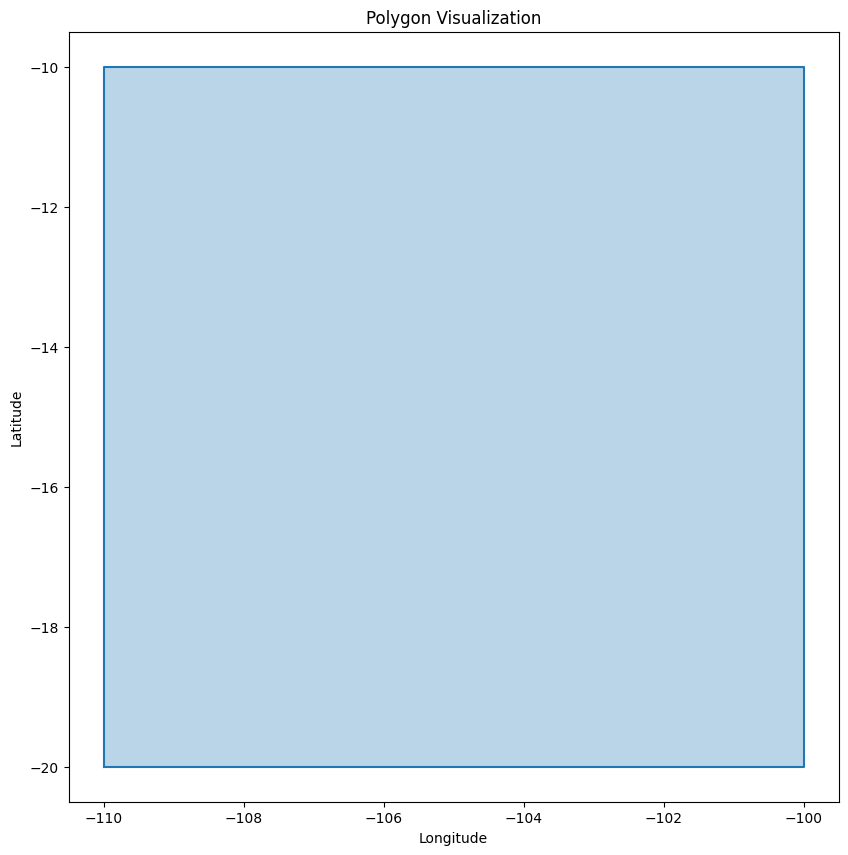

In [194]:
polygon = geometry

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the polygon
x, y = polygon.exterior.xy
ax.plot(x, y)

# Fill the polygon
ax.fill(x, y, alpha=0.3)

# Set the aspect of the plot to equal
ax.set_aspect('equal')

# Add title
ax.set_title("Polygon Visualization")

# Add labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()
